# Loan Status Prediction: Lending Club, 2007-2017

***By Joe Corliss***

## Table of Contents

(Currently outdated)

1. [Summary](#1)
    1. [Spoilers](#1.1)
2. [Import the Data](#2)
3. [Target Variable](#3)
4. [Feature Selection](#4)
    1. [Drop columns that have only one distinct value](#4.1)
    2. [Remove columns that have < 2% data](#4.2)
    3. [Remove irrelevant features](#4.3)
    4. [Remove features that could make predictions too easy](#4.4)
    5. [Inspect non-numerical features](#4.5)
5. [Exploratory Data Analysis](#5)
6. [Correlations with 'charged_off'](#6)
    1. [Create dummy variables](#6.1)
    2. [Compute correlations with 'charged_off'](#6.2)
7. [More Pre-processing](#7)
    1. [Train/test split](#7.1)
    2. [Imputation with mean substitution](#7.2)
    3. [Standardize the data](#7.3)
8. [Predictive Modeling: SGDClassifier](#8)
    1. [Train with grid search](#8.1)
    2. [Test set evaluation](#8.2)

# Introduction

[Data source on Kaggle](https://www.kaggle.com/wordsforthewise/lending-club)

[Notebook on Kaggle](https://www.kaggle.com/pileatedperch/predicting-loan-status-mcc-0-73)

[Lending Club Statistics](https://www.lendingclub.com/info/download-data.action)

[GitHub Repository](https://github.com/jgcorliss/lending-club)

The goal of this project is to predict whether a loan will be fully paid or charged off. We'll remove some features that would make this prediction too easy, such as the total payments received on the loan to date.

# Import the Data
<a id="2"></a>

Import basic libraries.

In [66]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Pandas options
pd.set_option('display.max_colwidth', 1000, 'display.max_rows', None, 'display.max_columns', None)

# Plotting options
%matplotlib inline
#mpl.style.use('ggplot')
sns.set(style='whitegrid')

Read in the data.

In [2]:
df = pd.read_csv('accepted_2007_to_2017Q3.csv.gz', compression='gzip')

C:\Users\Joe\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2728: DtypeWarning: Columns (0,18,48,58,117,128,129,130,133,134,135,138,144,145,146) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Check basic dataframe info.

In [3]:
df.shape

(1646801, 150)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1646801 entries, 0 to 1646800
Columns: 150 entries, id to settlement_term
dtypes: float64(113), object(37)
memory usage: 1.8+ GB


Sample some rows:

In [5]:
df.sample(3)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
91855,24745193,NaN,35000.0,35000.0,35000.0,36 months,8.39,1103.09,A,A5,Custom Applications Manager,8 years,MORTGAGE,126000.0,Verified,Aug-2014,Fully Paid,n,NaN,home_improvement,Home improvement,189xx,PA,21.71,0.0,Apr-1980,715.0,719.0,0.0,NaN,NaN,14.0,0.0,23246.0,75.5,31.0,f,0.00,0.00,39491.409212,39491.41,35000.00,4491.41,0.0,0.0,0.0,Dec-2016,9707.98,NaN,Aug-2017,789.0,785.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,474021.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30800.0,NaN,NaN,NaN,2.0,36463.0,5387.0,80.8,0.0,0.0,158.0,412.0,54.0,14.0,1.0,91.0,NaN,11.0,NaN,0.0,4.0,5.0,5.0,5.0,20.0,7.0,9.0,5.0,14.0,0.0,0.0,0.0,0.0,100.0,75.0,0.0,0.0,565935.0,64819.0,28000.0,93164.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
47519,31337298,NaN,12000.0,12000.0,12000.0,36 months,6.03,365.23,A,A1,Cultural/Visual Resource Specialist,3 years,MORTGAGE,75000.0,Not Verified,Oct-2014,Fully Paid,n,NaN,credit_card,Credit card refinancing,601xx,IL,12.30,0.0,Nov-1998,715.0,719.0,0.0,NaN,NaN,7.0,0.0,12877.0,92.0,24.0,f,0.00,0.00,12598.380000,12598.38,12000.00,598.38,0.0,0.0,0.0,Sep-2015,8954.12,NaN,Apr-2016,724.0,720.0,0.0,NaN,1.0,Individual,NaN,NaN,NaN,0.0,0.0,296500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14000.0,NaN,NaN,NaN,3.0,49417.0,0.0,107.3,0.0,0.0,133.0,191.0,21.0,13.0,1.0,21.0,NaN,13.0,NaN,0.0,2.0,2.0,2.0,3.0,17.0,4.0,5.0,2.0,7.0,0.0,0.0,0.0,0.0,100.0,100.0,0.0,0.0,306557.0,118621.0,12000.0,111890.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,

# Response Variable
<a id="3"></a>

We're going to try to predict the `loan_status` column. What are the value counts in this column?

In [6]:
df['loan_status'].value_counts()

Current                                                788950
Fully Paid                                             646902
Charged Off                                            168084
Late (31-120 days)                                      23763
In Grace Period                                         10474
Late (16-30 days)                                        5786
Does not meet the credit policy. Status:Fully Paid       1988
Does not meet the credit policy. Status:Charged Off       761
Default                                                    70
Name: loan_status, dtype: int64

Let's only consider loans that meet the credit policy and have either been fully paid or charged off. These are the two cases we'll try to distinguish with a predictive model.

Retain only the rows with `loan_status` Fully Paid or Charged Off.

In [7]:
df = df.loc[df['loan_status'].isin(['Fully Paid', 'Charged Off'])]

In [8]:
df.shape

(814986, 150)

In [9]:
df['loan_status'].value_counts(normalize=True)

Fully Paid     0.793758
Charged Off    0.206242
Name: loan_status, dtype: float64

About 79% of the loans have been fully paid, and 21% have been charged off.

Let's convert the `loan_status` column to a 0/1 `charged_off` column.

In [10]:
df['loan_status'] = df['loan_status'].apply(lambda s: np.uint8(s == 'Charged Off'))

In [11]:
df['loan_status'].value_counts(normalize=True)

0    0.793758
1    0.206242
Name: loan_status, dtype: float64

Rename the `loan_status` column to `charged_off`.

In [12]:
df.rename(columns={'loan_status':'charged_off'}, inplace=True)

Our target variable is ready to go. We have two classes to try to predict.

# Feature Selection
<a id="4"></a>

The dataset has 150 features, but we won't be using all the features for our predictions, as we'll explain below.

Definitions of the columns are given in the Lending Club "Data Dictionary" [available here](https://www.lendingclub.com/info/download-data.action).

First let's locate columns with missing data:

## Missing Data

In [13]:
def incomplete_cols(df):
    """
    Returns a list of incomplete columns in df and their completion percentage.
    
    Input: pandas DataFrame
    Returns: pandas Series
    """
    cmp = df.notnull().mean()
    cmp = cmp.loc[cmp<1]
    dec = np.int64(np.ceil(np.log10(df.shape[0]))) - 2 # Number of decimal places based on no. of samples
    return cmp.apply(lambda val: str(np.round(100*val, decimals=dec))+'%')

In [14]:
incomplete_cols(df)

member_id                                         0.0%
emp_title                                     94.0403%
emp_length                                    94.8155%
desc                                          14.6913%
title                                         99.0284%
dti                                           99.9956%
inq_last_6mths                                99.9999%
mths_since_last_delinq                        48.8125%
mths_since_last_record                          16.46%
revol_util                                    99.9399%
last_pymnt_d                                  99.8198%
next_pymnt_d                                      0.0%
last_credit_pull_d                            99.9952%
collections_12_mths_ex_med                    99.9931%
mths_since_last_major_derog                   25.2047%
annual_inc_joint                               0.4637%
dti_joint                                      0.4637%
verification_status_joint                      0.4637%
tot_coll_a

There are LOTS of features with missing data.

## Drop features that have >30% missing data
<a id="4.2"></a>

Find the features to drop:

In [15]:
drop_list = []
for col in df.columns:
    if df[col].isnull().mean() > 0.3:
        drop_list.append(col)

drop_list

['member_id',
 'desc',
 'mths_since_last_delinq',
 'mths_since_last_record',
 'next_pymnt_d',
 'mths_since_last_major_derog',
 'annual_inc_joint',
 'dti_joint',
 'verification_status_joint',
 'open_acc_6m',
 'open_act_il',
 'open_il_12m',
 'open_il_24m',
 'mths_since_rcnt_il',
 'total_bal_il',
 'il_util',
 'open_rv_12m',
 'open_rv_24m',
 'max_bal_bc',
 'all_util',
 'inq_fi',
 'total_cu_tl',
 'inq_last_12m',
 'mths_since_recent_bc_dlq',
 'mths_since_recent_revol_delinq',
 'revol_bal_joint',
 'sec_app_fico_range_low',
 'sec_app_fico_range_high',
 'sec_app_earliest_cr_line',
 'sec_app_inq_last_6mths',
 'sec_app_mort_acc',
 'sec_app_open_acc',
 'sec_app_revol_util',
 'sec_app_open_act_il',
 'sec_app_num_rev_accts',
 'sec_app_chargeoff_within_12_mths',
 'sec_app_collections_12_mths_ex_med',
 'sec_app_mths_since_last_major_derog',
 'hardship_type',
 'hardship_reason',
 'hardship_status',
 'deferral_term',
 'hardship_amount',
 'hardship_start_date',
 'hardship_end_date',
 'payment_plan_start_

Drop these columns.

In [16]:
df.shape

(814986, 150)

In [17]:
df.drop(labels=drop_list, axis=1, inplace=True)

In [18]:
df.shape

(814986, 92)

## Remove irrelevant features
<a id="4.3"></a>

Let's drop some features that we don't think will be useful for predicting the loan status.

Analyzing text in the borrower loan description, job title, or loan title could be an interesting direction, but we won't explore this for now. The last three features listed below contain date information. We could convert these to numerical values, but we won't bother doing so.

In [19]:
df.shape

(814986, 92)

In [20]:
df.drop(labels=['id', 'emp_title', 'title', 'issue_d', 'last_credit_pull_d', 'earliest_cr_line'], axis=1, inplace=True)

In [21]:
df.shape

(814986, 86)

## Remove features that could make predictions too easy
<a id="4.4"></a>

Some features perfectly predict the loan status. For example, if `debt_settlement_flag` is 'Y', this implies that the borrower charged off. Also, if `total_pymnt` is greater than `loan_amnt`, and similarly for interest and fee payment features, then the loan must be paid off. Let's remove these columns so that predicting charge-offs isn't trivially simple.

In [22]:
df.shape

(814986, 86)

In [23]:
df.drop(labels=['collection_recovery_fee', 'debt_settlement_flag', 'last_pymnt_amnt', 'last_pymnt_d', 'recoveries', 'total_pymnt', 'total_pymnt_inv', 'total_rec_int', 'total_rec_late_fee', 'total_rec_prncp'], axis=1, inplace=True)

In [24]:
df.shape

(814986, 76)

## Inspect non-numerical features
<a id="4.5"></a>

We're going to inspect features of type `object`, i.e. text data.

In [25]:
df.sample(3)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_length,home_ownership,annual_inc,verification_status,charged_off,pymnt_plan,purpose,zip_code,addr_state,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method
434011,10000.0,10000.0,10000.0,60 months,12.29,223.92,C,C1,4 years,OWN,35000.0,Not Verified,0,n,debt_consolidation,986xx,WA,25.27,0.0,745.0,749.0,1.0,11.0,0.0,8312.0,21.9,17.0,w,0.0,0.0,764.0,760.0,0.0,1.0,Individual,0.0,0.0,12921.0,38000.0,1.0,1175.0,17550.0,20.9,0.0,0.0,113.0,109.0,5.0,5.0,0.0,26.0,5.0,0.0,3.0,4.0,5.0,9.0,4.0,9.0,13.0,4.0,11.0,0.0,0.0,0.0,1.0,100.0,0.0,0.0,0.0,54675.0,12921.0,22200.0,16675.0,N,Cash
1067155,12000.0,12000.0,12000.0,60 months,23.99,345.15,E,E2,6 years,RENT,45000.0,Verified,0,n,debt_consolidation,460xx,IN,9.97,0.0,695.0,699.0,0.0,7.0,0.0,4982.0,49.3,14.0,w,0.0,0.0,684.0,680.0,0.0,1.0,Individual,0.0,0.0,8993.0,10100.0,2.0,1285.0,4027.0,47.0,0.0,0.0,105.0,136.0,12.0,9.0,1.0,12.0,24.0,0.0,5.0,6.0,5.0,5.0,6.0,6.0,7.0,6.0,7.0,0.0,0.0,0.0,2.0,100.0,40.0,0.0,0.0,15100.0,8993.0,7600.0,5000.0,N,Cash
533106,5000.0,5000.0,5000.0,36 months,6.24,152.66,A,A2,3 years,MORTGAGE,55000.0,Not Verified,0,n,major_purchase,599xx,MT,6.52,0.0,740.0,744.0,0.0,5.0,0.0,0.0,0.0,10.0,w,0.0,0.0,744.0,740.0,0.0,1.0,Individual,0.0,0.0,228421.0,5300.0,7.0,45684.0,2500.0,0.0,0.0,0.0,41.0,52.0,2.0,2.0,1.0,4.0,16.0,0.0,0.0,0.0,1.0,3.0,4.0,3.0,5.0,0.0,5.0,0.0,0.0,0.0,3.0,100.0,0.0,0.0,0.0,239981.0,14419.0,2500.0,19375.0,N,Cash


Which columns have text data?

In [26]:
text_cols = []
for col in df.columns:
    if df[col].dtype == np.object:
        text_cols.append(col)

text_cols

['term',
 'grade',
 'sub_grade',
 'emp_length',
 'home_ownership',
 'verification_status',
 'pymnt_plan',
 'purpose',
 'zip_code',
 'addr_state',
 'initial_list_status',
 'application_type',
 'hardship_flag',
 'disbursement_method']

### term

In [27]:
df['term'].value_counts()

 36 months    618460
 60 months    196526
Name: term, dtype: int64

Convert `term` to integer values.

In [ ]:
df['term'] = df['term'].apply(lambda s:np.int64(s[1:3])) # There's an extra space in the data for some reason

In [58]:
df['term'].value_counts()

36.0    618460
60.0    196526
Name: term, dtype: int64

### grade, sub_grade

In [34]:
df['grade'].value_counts().sort_index()

A    133475
B    235225
C    225917
D    127665
E     63559
F     23112
G      6033
Name: grade, dtype: int64

The grade is implied by the subgrade, so let's drop the grade column.

In [35]:
df.drop(labels=['grade'], axis=1, inplace=True)

### emp_length

In [37]:
df['emp_length'].value_counts().sort_index()

1 year        53411
10+ years    264873
2 years       73493
3 years       64999
4 years       48752
5 years       52149
6 years       40290
7 years       39407
8 years       38887
9 years       31900
< 1 year      64572
Name: emp_length, dtype: int64

Let's convert `emp_length` to floats:

In [38]:
def emp_conv(s):
    try:
        if pd.isnull(s):
            return s
        elif s[0] == '<':
            return 0.0
        elif s[:2] == '10':
            return 10.0
        else:
            return np.float(s[0])
    except TypeError:
        return np.float64(s)

In [ ]:
df['emp_length'] = df['emp_length'].apply(lambda s: emp_conv(s))

In [42]:
df['emp_length'].value_counts().sort_index()

0.0      64572
1.0      53411
2.0      73493
3.0      64999
4.0      48752
5.0      52149
6.0      40290
7.0      39407
8.0      38887
9.0      31900
10.0    264873
Name: emp_length, dtype: int64

### home_ownership

In [43]:
df['home_ownership'].value_counts()

MORTGAGE    406866
RENT        325071
OWN          82765
OTHER          144
ANY             94
NONE            46
Name: home_ownership, dtype: int64

### verification_status

In [44]:
df['verification_status'].value_counts()

Source Verified    293897
Verified           269895
Not Verified       251194
Name: verification_status, dtype: int64

### purpose

In [45]:
df['purpose'].value_counts()

debt_consolidation    481652
credit_card           175123
home_improvement       50793
other                  43900
major_purchase         17463
small_business         10214
car                     8936
medical                 8772
moving                  5725
vacation                5116
house                   4095
wedding                 2272
renewable_energy         599
educational              326
Name: purpose, dtype: int64

### zip_code, addr_state

In [47]:
df['zip_code'].nunique()

925

In [46]:
df['zip_code'].value_counts()

945xx    9517
750xx    8851
112xx    8378
606xx    7580
300xx    7235
331xx    6952
100xx    6749
900xx    6715
070xx    6612
891xx    6408
770xx    6228
917xx    6054
330xx    5945
104xx    5560
117xx    5383
921xx    5352
852xx    5282
926xx    5064
913xx    4931
925xx    4847
334xx    4509
956xx    4381
113xx    4302
481xx    4251
853xx    4197
928xx    4118
021xx    4105
920xx    4061
980xx    4049
080xx    4044
601xx    4027
802xx    4015
604xx    3955
760xx    3849
600xx    3835
850xx    3791
301xx    3767
941xx    3766
773xx    3759
201xx    3702
207xx    3639
951xx    3621
923xx    3600
774xx    3584
902xx    3538
800xx    3445
480xx    3366
088xx    3303
114xx    3285
275xx    3280
840xx    3271
953xx    3240
212xx    3218
782xx    3206
553xx    3200
333xx    3190
554xx    3188
958xx    3169
940xx    3126
752xx    3105
787xx    3023
303xx    3007
890xx    2993
786xx    2984
327xx    2967
328xx    2946
775xx    2933
967xx    2924
605xx    2837
801xx    2815
191xx    2753
483xx 

In [48]:
df['addr_state'].nunique()

51

In [49]:
df['addr_state'].value_counts()

CA    124204
NY     66555
TX     65432
FL     57237
IL     30874
NJ     29578
PA     27801
OH     26291
GA     26048
VA     23771
NC     22863
MI     20878
AZ     19737
MD     18902
MA     18816
CO     18427
WA     18182
MN     14532
MO     12794
IN     12442
NV     12280
TN     11654
CT     11550
WI     10387
OR     10345
AL     10212
LA      9504
SC      9467
KY      7705
OK      7295
KS      6801
UT      6434
AR      6062
NM      4608
HI      4278
NH      3774
RI      3505
WV      3272
MS      3269
MT      2329
DC      2278
DE      2251
AK      2077
WY      1830
SD      1683
VT      1548
NE      1407
ME       681
ND       607
ID       522
IA         7
Name: addr_state, dtype: int64

There are a lot of zip codes, so let's just retain the state column.

In [50]:
df.drop(labels=['zip_code'], axis=1, inplace=True)

### initial_list_status

In [51]:
df['initial_list_status'].value_counts()

f    413678
w    401308
Name: initial_list_status, dtype: int64

I wasn't able to determine what the initial list status means.

### application_type

In [52]:
df['application_type'].value_counts()

Individual    811207
Joint App       3779
Name: application_type, dtype: int64

### disbursement_method

In [53]:
df['disbursement_method'].value_counts()

Cash         813877
DirectPay      1109
Name: disbursement_method, dtype: int64

# Exploratory Data Analysis
<a id="5"></a>

View some random rows:

In [54]:
df.sample(3)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,charged_off,pymnt_plan,purpose,addr_state,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,application_type,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,hardship_flag,disbursement_method
620301,28000.0,28000.0,28000.0,36.0,9.17,892.61,B2,10.0,MORTGAGE,105000.0,Source Verified,0,n,home_improvement,PA,13.20,0.0,710.0,714.0,0.0,13.0,0.0,21272.0,62.0,37.0,f,0.0,0.0,744.0,740.0,0.0,1.0,Individual,0.0,0.0,197566.0,34300.0,4.0,16464.0,3536.0,73.4,0.0,0.0,125.0,339.0,7.0,7.0,2.0,7.0,18.0,0.0,3.0,6.0,3.0,11.0,15.0,9.0,20.0,6.0,13.0,0.0,0.0,0.0,2.0,91.9,66.7,0.0,0.0,266622.0,32366.0,13300.0,16522.0,N,Cash
1537098,16700.0,16700.0,16700.0,60.0,18.99,433.12,D4,1.0,RENT,93600.0,Verified,0,n,debt_consolidation,NE,11.52,2.0,715.0,719.0,0.0,14.0,1.0,1265.0,5.8,21.0,w,0.0,0.0,724.0,720.0,0.0,1.0,Individual,0.0,0.0,33426.0,21800.0,3.0,2388.0,12206.0,7.5,0.0,0.0,83.0,133.0,7.0,3.0,0.0,7.0,7.0,2.0,3.0,4.0,5.0,6.0,7.0,10.0,14.0,4.0,14.0,0.0,0.0,2.0,3.0,90.5,0.0,0.0,0.0,57469.0,33426.0,13200.0,35669.0,N,Cash
950486,7000.0,7000.0,7000.0,36.0,13.11,236.23,B4,0.0,RENT,95000.0,Not Verified,0,n,debt_consolidation,NY,3.71,0.0,685.0,689.0,1.0,12.0,0.0,3871.0,28.5,14.0,f,0.0,0.0,779.0,775.0,0.0,1.0,Individual,0.0,0.0,7000.0,13600.0,7.0,636.0,1731.0,62.4,0.0,0.0,14.0,70.0,2.0,2.0,0.0,2.0,2.0,0.0,5.0,6.0,5.0,6.0,1.0,10.0,12.0,6.0,12.0,0.0,0.0,0.0,2.0,100.0,60.0,0.0,0.0,18728.0,7000.0,4600.0,1833.0,N,Cash


Let's make a count plot of the loan purpose, separated by the `charged_off` value.

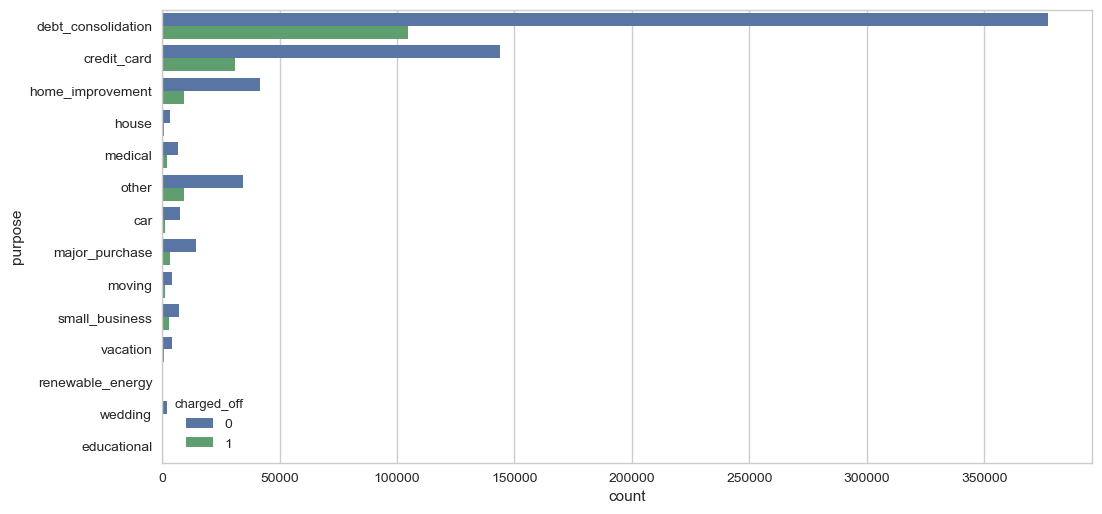

In [55]:
plt.figure(figsize=(12,6), dpi=100)
sns.countplot(y='purpose', hue='charged_off', data=df, orient='h')

It appears that most of the charge-offs come from loans for debt consolidation or to pay off credit cards.

Let's make a similar plot, but with `sub_grade` instead of `purpose`.

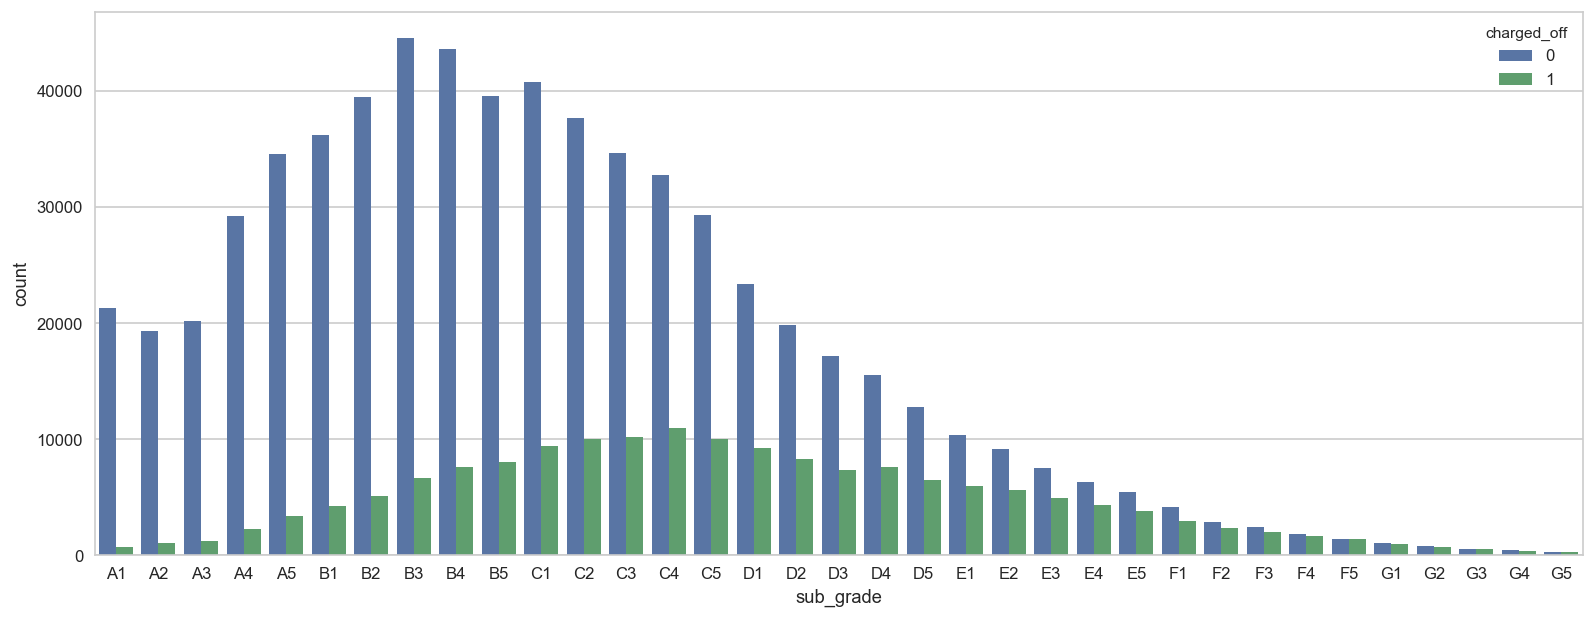

In [56]:
plt.figure(figsize=(16,6), dpi=120)
sns.countplot(x='sub_grade', hue='charged_off', data=df, order=sorted(df['sub_grade'].value_counts().index))

There's a clear trend of higher probability of charge-off as the subgrade worsens.

Let's make a similar plot, but with `term` instead of `sub_grade`.

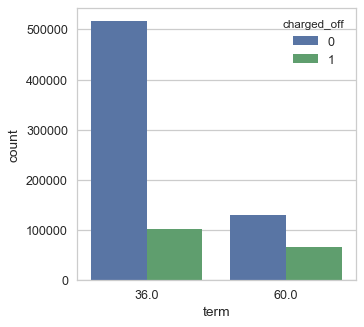

In [57]:
plt.figure(figsize=(4,4), dpi=90)
sns.countplot(x='term', hue='charged_off', data=df)

Loans with a term of 60 months are much more likely to be charged off.

Now let's compare the interest rate to the loan status using a kdeplot, which approximates the probability distribution of the data.

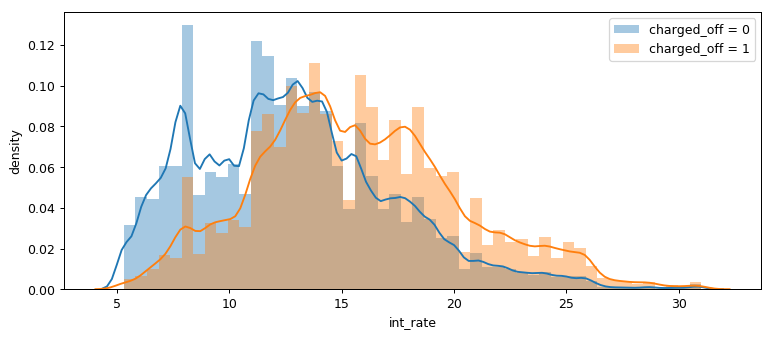

In [71]:
plt.figure(figsize=(10,4), dpi=90)
sns.distplot(df['int_rate'].loc[df['charged_off']==0], kde=True, label='charged_off = 0')
sns.distplot(df['int_rate'].loc[df['charged_off']==1], kde=True, label='charged_off = 1')
plt.xlabel('int_rate')
plt.ylabel('density')
plt.legend()

Charged-off loans tend to have higher interest rates.

Now let's compare the borrower's most recent FICO score (a credit score) to the loan status.

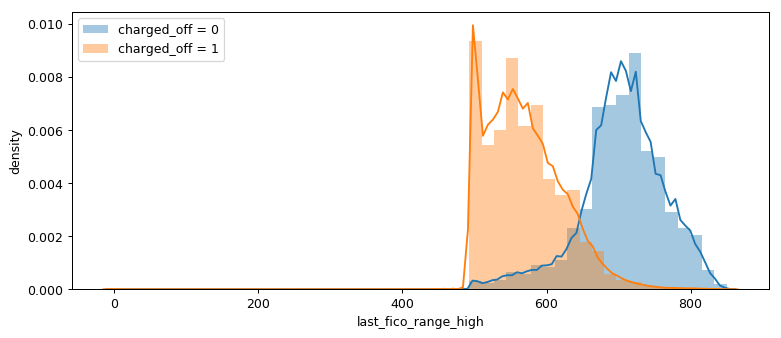

In [72]:
plt.figure(figsize=(10,4), dpi=90)
sns.distplot(df['last_fico_range_high'].loc[df['charged_off']==0], label='charged_off = 0')
sns.distplot(df['last_fico_range_high'].loc[df['charged_off']==1], label='charged_off = 1')
plt.xlabel('last_fico_range_high')
plt.ylabel('density')
plt.legend()

There's a strong association here: charged-off loans tend to have much lower FICO scores.

# Correlations with 'charged_off'
<a id="6"></a>

By studying correlation coefficients, we can get an idea of which features correlate most strongly with 'charged_off'.

## Create dummy variables
<a id="6.1"></a>

To study correlations with 'charged_off', we need to convert categorial features to dummy variables.

In [73]:
cat_feats = []
for col in df.columns:
    if df[col].dtype == np.object:
        cat_feats.append(col)

cat_feats

['sub_grade',
 'home_ownership',
 'verification_status',
 'pymnt_plan',
 'purpose',
 'addr_state',
 'initial_list_status',
 'application_type',
 'hardship_flag',
 'disbursement_method']

In [74]:
df.shape

(814986, 74)

In [75]:
df = pd.get_dummies(df, dummy_na=True, drop_first=True)

In [76]:
df.shape

(814986, 181)

Now all the features are numerical. What does the data look like after converting categorical features to dummy variables?

In [78]:
df.sample(3)

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,emp_length,annual_inc,charged_off,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,policy_code,acc_now_delinq,tot_coll_amt,tot_cur_bal,total_rev_hi_lim,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_inq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,sub_grade_nan,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,home_ownership_nan,verification_status_Source Verified,verification_status_Verified,verification_status_nan,pymnt_plan_nan,purpose_credit_card,purpose_debt_consolidation,purpose_educational,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,purpose_nan,addr_state_AL,addr_state_AR,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_CT,addr_state_DC,addr_state_DE,addr_state_FL,addr_state_GA,addr_state_HI,addr_state_IA,addr_state_ID,addr_state_IL,addr_state_IN,addr_state_KS,addr_state_KY,addr_state_LA,addr_state_MA,addr_state_MD,addr_state_ME,addr_state_MI,addr_state_MN,addr_state_MO,addr_state_MS,addr_state_MT,addr_state_NC,addr_state_ND,addr_state_NE,addr_state_NH,addr_state_NJ,addr_state_NM,addr_state_NV,addr_state_NY,addr_state_OH,addr_state_OK,addr_state_OR,addr_state_PA,addr_state_RI,addr_state_SC,addr_state_SD,addr_state_TN,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,addr_state_WI,addr_state_WV,addr_state_WY,addr_state_nan,initial_list_status_w,initial_list_status_nan,application_type_Joint App,application_type_nan,hardship_flag_nan,disbursement_method_DirectPay,disbursement_method_nan
928935,8650.0,8650.0,8650.0,36.0,18.75,315.99,4.0,29950.0,1,16.00,0.0,670.0,674.0,0.0,6.0,0.0,12302.0,91.1,8.0,0.0,0.0,664.0,660.0,0.0,1.0,0.0,0.0,12302.0,13500.0,2.0,2050.0,690.0,93.8,0.0,0.0,NaN,88.0,9.0,9.0,0.0,50.0,17.0,0.0,3.0,5.0,3.0,4.0,0.0,6.0,8.0,5.0,6.0,0.0,0.0,0.0,2.0,100.0,100.0,0.0,0.0,13500.0,12302.0,11100.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
599113,4425.0,4425.0,4425.0,36.0,18.25,160.53,NaN,24000.0,1,25.65,1.0,675.0,679.0,0.0,8.0,0.0,8230.0,56.0,22.0,0.0,0.0,529.0,525.0,0.0,1.0,0.0,0.0,13061.0,14700.0,3.0,1633.0,5708.0,51.6,0.0,0.0,11.0,181.0,5.0,5.0,0.0,5.0,NaN,2.0,4.0,5.0,5.0,17.0,1.0,7.0,21.0,5.0,8.0,0.0,0.0,1.0,2.0,86.4,20.0,0.0,0.0,20700.0,13061.0,11800.0,6000.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
338617,15000.0,15000.0,15000.0,36.0,13.18,506.72,9.0,95000.0,0,31.06,0.0,665.0,669.0,0.0,19.0,0.0,30

## Compute correlations with 'charged_off'
<a id="6.2"></a>

Create the correlation matrix of all our data, then extract the `charged_off` column. Remove the entry for `charged_off` (it's 1), and sort the features by their correlation coefficient with `charged_off`.

In [79]:
corr_charged_off = df.corr()['charged_off']

In [80]:
corr_charged_off.drop(labels='charged_off', inplace=True)
corr_charged_off = corr_charged_off.sort_values()

Plot the correlation coefficients.

(-0.6866086165148878, 0.6866086165148878)

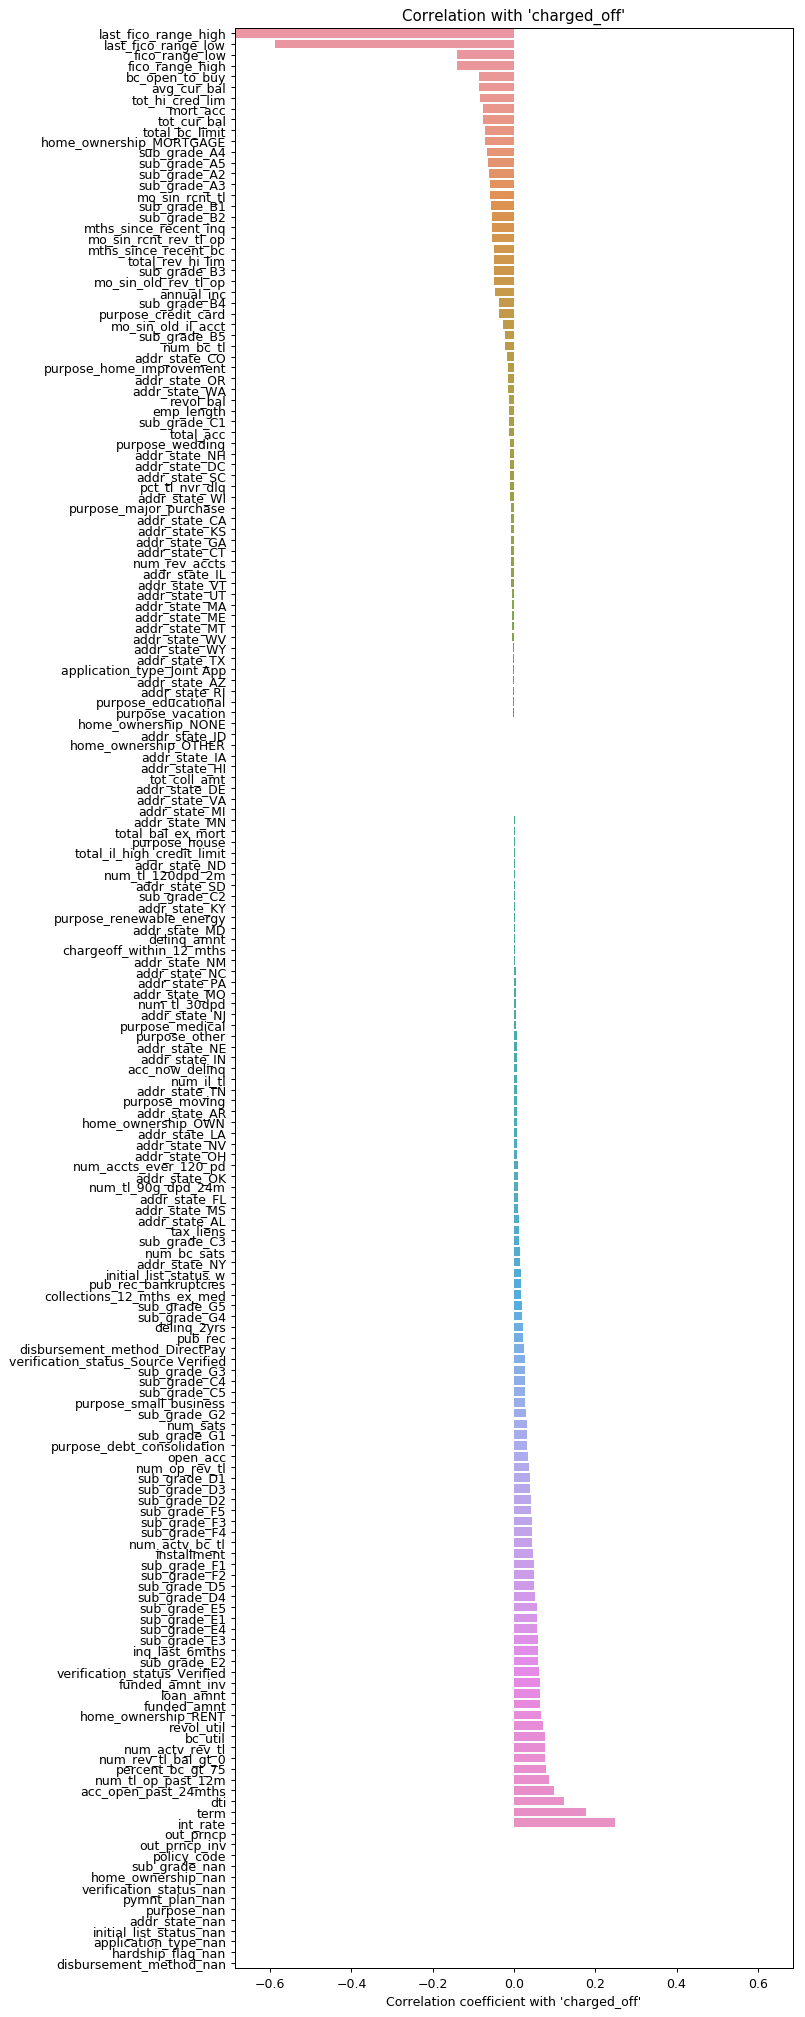

In [81]:
plt.figure(figsize=(8,28), dpi=90)
sns.barplot(y=corr_charged_off.index, x=corr_charged_off.values, orient='h')
plt.title("Correlation with 'charged_off'")
plt.xlabel("Correlation coefficient with 'charged_off'")
xmax = np.abs(corr_charged_off).max()
plt.xlim([-xmax, xmax])

**Things to note:** The borrower's most recent FICO scores are the features most negatively correlated with `charged_off`. The debt-to-income ratio (`dti`), the number of payments on the loan (`term`), and the interest rate (`int_rate`) are the features most positively correlated with `charged_off`.

# More Pre-processing
<a id="7"></a>

Let's remind ourselves how many samples/features we have.

In [86]:
df.shape

(814986, 181)

## Train/test split
<a id="7.1"></a>

In [87]:
X = df.drop(labels=['charged_off'], axis=1) # Features
y = df.loc[:,'charged_off'] # Response variable
df = None

In [88]:
from sklearn.model_selection import train_test_split

Let's do a 90/10 train/test split.

In [89]:
random_state = 1 # Just to make the results fixed
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random_state, stratify=y)
X = None
y = None

## Imputation with mean substitution
<a id="7.2"></a>

How complete is our training data?

In [91]:
incomplete_cols(X_train)

emp_length                    94.8144%
dti                           99.9955%
inq_last_6mths                99.9999%
revol_util                    99.9396%
collections_12_mths_ex_med     99.993%
tot_coll_amt                  91.7258%
tot_cur_bal                   91.7258%
total_rev_hi_lim              91.7258%
acc_open_past_24mths          94.2105%
avg_cur_bal                   91.7242%
bc_open_to_buy                93.2441%
bc_util                       93.1845%
chargeoff_within_12_mths       99.993%
mo_sin_old_il_acct            89.0249%
mo_sin_old_rev_tl_op          91.7257%
mo_sin_rcnt_rev_tl_op         91.7257%
mo_sin_rcnt_tl                91.7258%
mort_acc                      94.2105%
mths_since_recent_bc          93.3169%
mths_since_recent_inq          85.586%
num_accts_ever_120_pd         91.7258%
num_actv_bc_tl                91.7258%
num_actv_rev_tl               91.7258%
num_bc_sats                   93.1642%
num_bc_tl                     91.7258%
num_il_tl                

The learning algorithms cannot have missing data. Perform mean substitution, using only the means of the training set to prevent test set leakage.

**Note:** I don't know that this is the best way to handle missing data. Should some columns simply be dropped? Should we impute some other way? Should incomplete rows be dropped?

In [92]:
from sklearn.preprocessing import Imputer

In [93]:
imputer = Imputer().fit(X_train)

In [94]:
X_train = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns)
X_test  = pd.DataFrame(imputer.transform(X_test),  columns=X_test.columns)

## Standardize the data
<a id="7.3"></a>

Shift and scale each column individually so that it has zero mean and unit variance. This will help the learning algorithms.

Train the scaler using only the training data to prevent test set leakage.

In [95]:
from sklearn.preprocessing import StandardScaler

In [96]:
scaler = StandardScaler().fit(X_train)

In [97]:
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test  = pd.DataFrame(scaler.transform(X_test),  columns=X_test.columns)

# Predictive Modeling: SGDClassifier
<a id="8"></a>

I decided to use a SGD Classifier by looking at the machine learning flowchart here: http://scikit-learn.org/stable/tutorial/machine_learning_map/index.html.

The SGDClassifier estimator implements linear classifiers (SVM, logistic regression, a.o.) with SGD training. The linear classifier is chosen by the 'loss' hyperparameter.

In [98]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import matthews_corrcoef, make_scorer

## Automatic feature selection

Add this here...

## Train with grid search
<a id="8.1"></a>

We're going to search through many hyperparameters of SGDClassifier using an exhaustive grid search with 3-fold cross-validation, implemented in GridSearchCV.

Here are the hyperparameters that we'll try:

In [99]:
param_grid = [{'loss': ['hinge'],
               'alpha': [10.0**k for k in range(-3,4)],
               'max_iter': [1000],
               'tol': [1e-3],
               'random_state': [random_state],
               'class_weight': [None, 'balanced'],
               'warm_start': [True]},
              {'loss': ['log'],
               'penalty': ['l2', 'l1'],
               'alpha': [10.0**k for k in range(-3,4)],
               'max_iter': [1000],
               'tol': [1e-3],
               'random_state': [random_state],
               'warm_start': [True]}]

Instantiate the grid estimator. We'll use the Matthews correlation coefficient as our scoring metric.

In [101]:
grid = GridSearchCV(estimator=SGDClassifier(), param_grid=param_grid, scoring=make_scorer(matthews_corrcoef), n_jobs=4, pre_dispatch=8, verbose=1)

Run the grid search (this could take some time).

In [102]:
grid.fit(X_train, y_train)

Fitting 3 folds for each of 28 candidates, totalling 84 fits


[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:  3.6min
[Parallel(n_jobs=4)]: Done  84 out of  84 | elapsed: 10.2min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=None, n_iter=None,
       n_jobs=1, penalty='l2', power_t=0.5, random_state=None,
       shuffle=True, tol=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid=[{'loss': ['hinge'], 'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0], 'max_iter': [1000], 'tol': [0.001], 'random_state': [1], 'class_weight': [None, 'balanced'], 'warm_start': [True]}, {'loss': ['log'], 'penalty': ['l2', 'l1'], 'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0], 'max_iter': [1000], 'tol': [0.001], 'random_state': [1], 'warm_start': [True]}],
       pre_dispatch=8, refit=True, return_train_score='warn',
       scoring=make_scorer(matthews_corrcoef), verbose=1)

Hyperparameters that gave the best results on the hold out data:

In [103]:
grid.best_params_

{'alpha': 0.01,
 'class_weight': 'balanced',
 'loss': 'hinge',
 'max_iter': 1000,
 'random_state': 1,
 'tol': 0.001,
 'warm_start': True}

Mean cross-validated MCC score of the best estimator:

In [105]:
grid.best_score_

0.7373004602043011

Weights assigned to the features by the best estimator:

Text(0.5,0,'classifier weight')

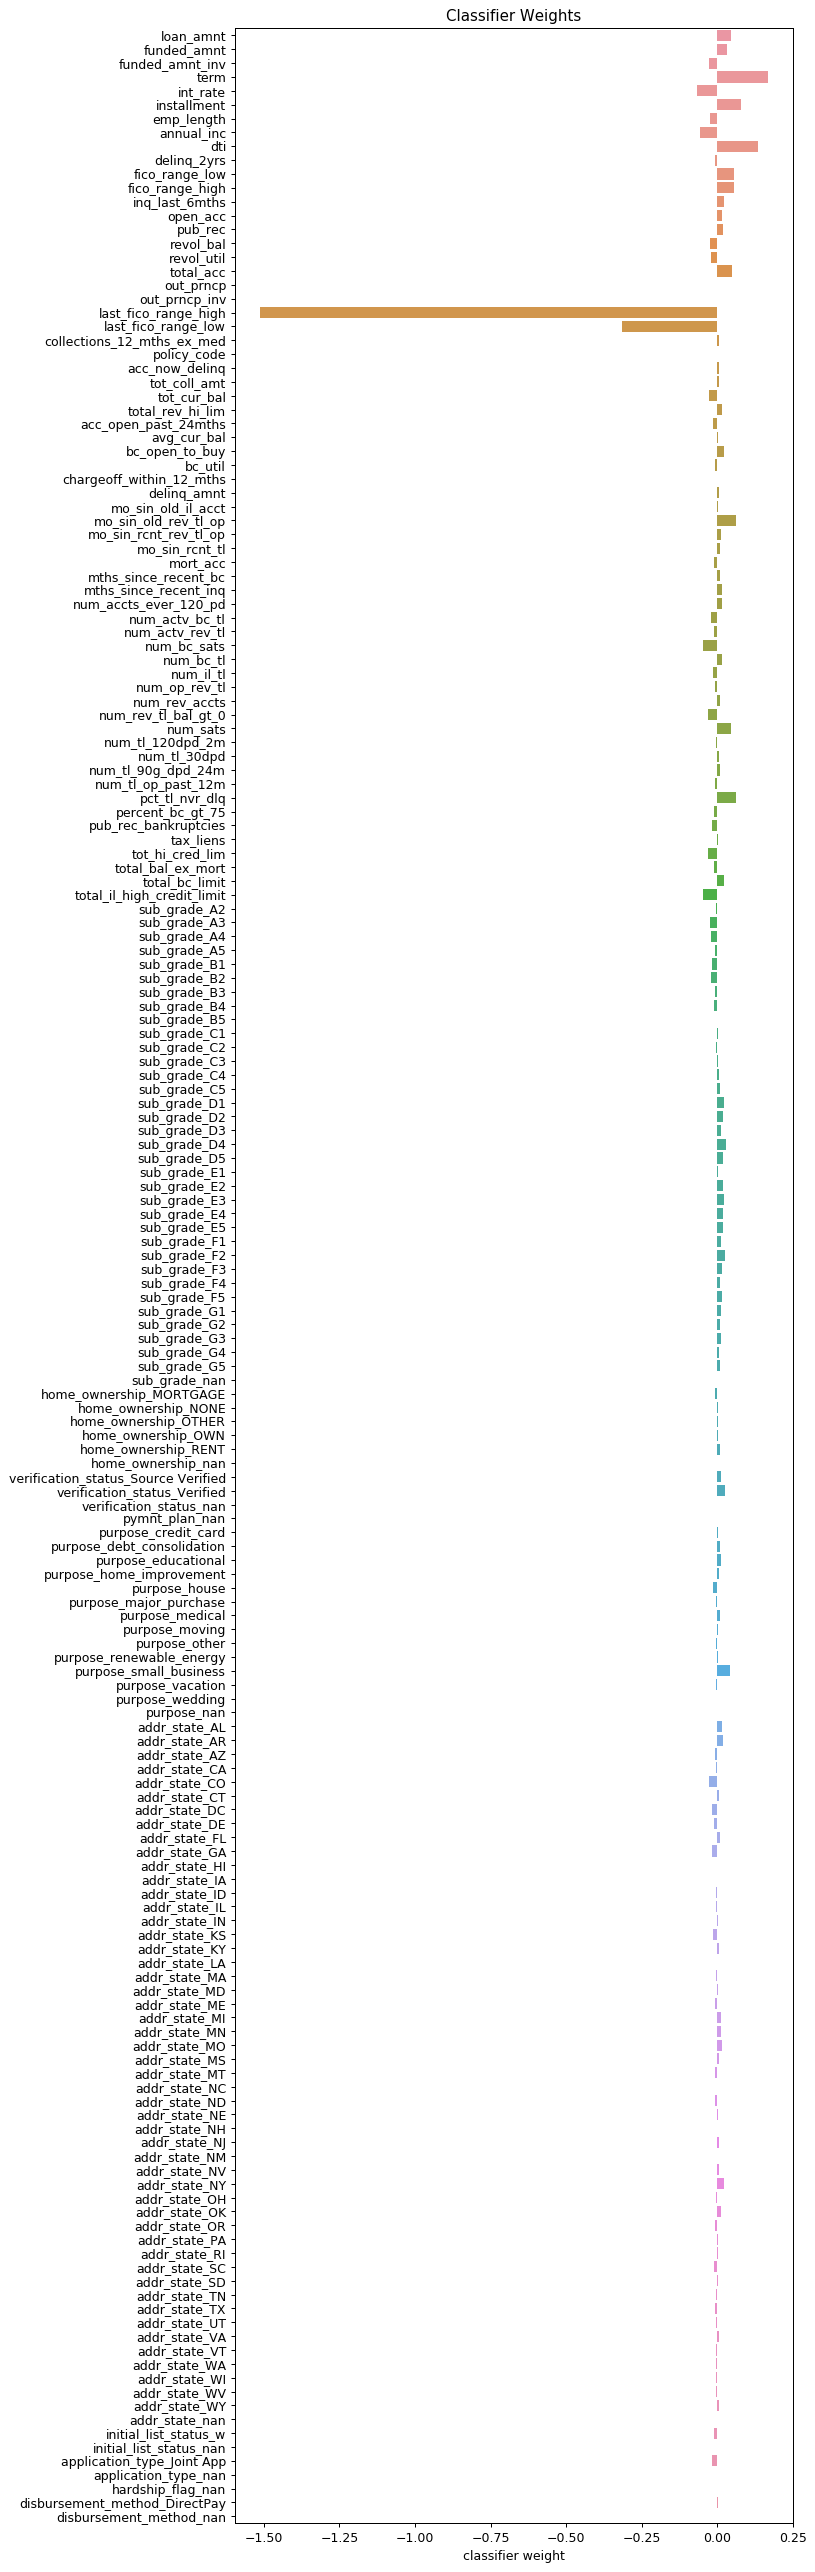

In [125]:
plt.figure(figsize=(8,36), dpi=90)
sns.barplot(y=X_train.columns, x=grid.best_estimator_.coef_[0,:], orient='h')
plt.title("Classifier Weights")
plt.xlabel("classifier weight")

## Test set evaluation
<a id="8.2"></a>

In [107]:
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef, cohen_kappa_score, accuracy_score, average_precision_score, roc_auc_score

In [108]:
def classification_eval(estimator, X_test, y_test):
    """
    Print several metrics of classification performance of an estimator, given features X_test and labels y_test.
    
    Input: estimator or GridSearchCV instance, X_test, y_test
    Returns: text printout of metrics
    """
    y_pred = estimator.predict(X_test)
    
    # Number of decimal places based on number of samples
    dec = np.int64(np.ceil(np.log10(len(y_test))))
    
    print('Confusion matrix -----------------------'+3*(dec-1)*'-')
    print(confusion_matrix(y_test, y_pred), '\n')
    
    print('Classification report ------------------'+3*(dec-1)*'-')
    print(classification_report(y_test, y_pred, digits=dec))
    
    print('Scalar metrics -------------------------'+3*(dec-1)*'-')
    format_str = '%%13s = %%.%if' % dec
    print(format_str % ('MCC', matthews_corrcoef(y_test, y_pred)))
    if y_test.nunique() <= 2: # Additional metrics for binary classification
        try:
            y_score = estimator.predict_proba(X_test)[:,1]
        except:
            y_score = estimator.decision_function(X_test)
        print(format_str % ('AUPRC', average_precision_score(y_test, y_score)))
        print(format_str % ('AUROCC', roc_auc_score(y_test, y_score)))
    print(format_str % ("Cohen's kappa", cohen_kappa_score(y_test, y_pred)))
    print(format_str % ('Accuracy', accuracy_score(y_test, y_pred)))

Test set evaluation metrics:

In [111]:
classification_eval(grid, X_test, y_test)

Confusion matrix -----------------------------------
[[58569  6122]
 [ 1738 15070]] 

Classification report ------------------------------
             precision    recall  f1-score   support

          0    0.97118   0.90537   0.93712     64691
          1    0.71112   0.89660   0.79316     16808

avg / total    0.91755   0.90356   0.90743     81499

Scalar metrics -------------------------------------
          MCC = 0.73971
        AUPRC = 0.81927
       AUROCC = 0.95242
Cohen's kappa = 0.73136
     Accuracy = 0.90356
